In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# 1) Preparando terreno

In [2]:
def image2array(nome_arquivo, startHeight = 0, startWidth = 0):
    """
    Converte uma imagem em um array NumPy normalizado (float32).

    Parameters
    ----------
    nome_arquivo : str
        O caminho para o arquivo de imagem.
    startHeight : int, optional
        A altura inicial para começar a leitura dos pixels (default é 0).
    startWidth : int, optional
        A largura inicial para começar a leitura dos pixels (default é 0).

    Returns
    -------
    np.ndarray
        Um array NumPy de forma (altura-startHeight, largura-startWidth, 3) contendo os valores normalizados (float32) dos pixels da imagem.
    """
    imagem = Image.open(nome_arquivo)
    largura, altura = imagem.size

    matriz_pixels = np.zeros((altura-startHeight, largura-startWidth, 3), dtype=np.float32)
    for y in range(startHeight, altura):
        for x in range(startWidth, largura):
            r, g, b = imagem.getpixel((x, y))
            matriz_pixels[y-startHeight, x-startWidth] = [r/255, g/255, b/255]
    return matriz_pixels

def array2image(matriz_pixels):
    """
    Converte um array NumPy em uma imagem e mostra a image.

    Parameters
    ----------
    array : np.ndarray
        Um array NumPy de forma (altura, largura, 3) contendo os valores dos pixels da imagem. Os valores devem estar no intervalo [0, 1].

    Returns
    -------
    None
    """
    altura, largura, _ = matriz_pixels.shape
    imagem = Image.new('RGB', (largura, altura))
    for y in range(altura):
        for x in range(largura):
            r, g, b = matriz_pixels[y, x]
            imagem.putpixel((x, y), (int(r*255), int(g*255), int(b*255)))
    # Display image using matplotlib
    imagem.show()

def flatIdx2pos(idx, width):
    return (idx//width, idx%width)

def pos2flatIdx(pos, width):
    return pos[0]*width + pos[1]

In [3]:
# Carrega imagem
sH = 1009
sW = 1722
fullW, fullH = (2722, 2009)
# Imagem recortada
imarr = image2array('datasets/vangogh.jpg', startHeight=sH, startWidth=sW)
#array2image(imarr)

In [4]:
# Transforma matriz bidimensional para array com pixels
altura, largura = imarr.shape[0], imarr.shape[1]
W = largura
total_pixels = altura * largura

imarr_flat = imarr.reshape(total_pixels, 3)
print(f"{altura} x {largura} = {total_pixels} pixels")
np.save(f'datasets/vangogh{fullH - sH}x{fullW - sW}.npy', imarr_flat)

1000 x 1000 = 1000000 pixels


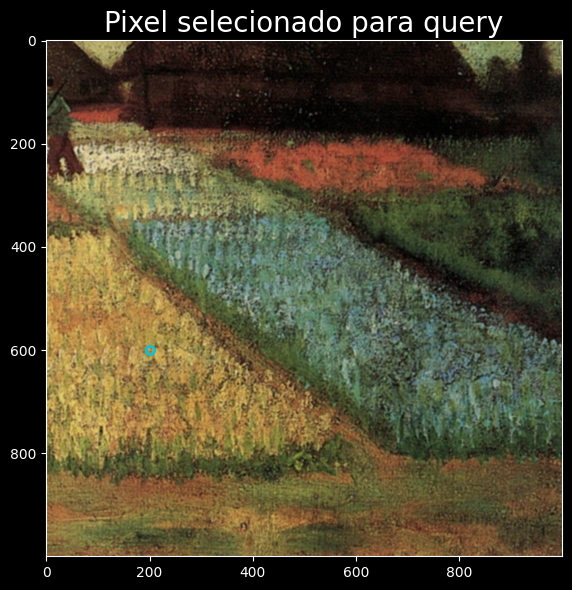

In [5]:
# Plota imagem e ponto usado para query
plt.figure(figsize=(6, 6))
plt.imshow(imarr)
x = 200
y = 600
plt.plot(x, y, 'o', color='tab:cyan', mfc='none', mew=2)
plt.title('Pixel selecionado para query', fontsize=20)
plt.tight_layout()

In [6]:
def L2(query, features):
    # Compute L2 distance between query and features
    return np.sqrt(np.sum((query - features)**2, axis=1))

def knn(query, k, features, distFunc = None, tie = 0):
    """
    Realiza uma busca k-NN (k-Nearest Neighbors) utilizando uma função de distância personalizada.

    Parameters
    ----------
    query : np.ndarray
        O vetor de consulta para o qual os vizinhos mais próximos serão encontrados.
    k : int
        O número de vizinhos mais próximos a serem retornados.
    features : np.ndarray
        Um array 2D onde cada linha é um vetor de características.
    distFunc : callable, optional
        A função de distância a ser utilizada. Se None, a função L2 (distância Euclidiana) será utilizada (default é None).
    tie : int, optional
        Se 1, verifica se há mais características com a mesma distância que o k-ésimo vizinho mais próximo e as inclui no resultado (default é 0).

    Returns
    -------
    list of tuple
        Uma lista de tuplas onde cada tupla contém o índice e a distância do vizinho mais próximo no array de características.
        A lista é ordenada pela distância em ordem crescente.

    Notes
    -----
    Em caso de empate (distâncias iguais) e se `tie` for 1, todos os vizinhos com a mesma distância que o k-ésimo vizinho mais próximo são incluídos no resultado.
    """
    if distFunc is None:
        distFunc = L2
    
    # Vetor com distâncias
    distances = distFunc(query, features)
    k_nearest = []
     
    for i in range(k):
        min_idx = np.argmin(distances)
        k_nearest.append((min_idx, distances[min_idx]))
        distances[min_idx] = np.inf
        
    # Check if there are more features with the same distance
    if tie:
        min_idx = np.argmin(distances)
        while distances[min_idx] == k_nearest[-1][1]:
            k_nearest.append((min_idx, distances[min_idx]))
            distances[min_idx] = np.inf
            min_idx = np.argmin(distances)
    
    return k_nearest

In [7]:
query = imarr_flat[pos2flatIdx((y, x), W)]
#query = np.array([192/255, 147/255, 80/255], dtype=np.float32)
features = np.load(f'datasets/vangogh{fullH - sH}x{fullW - sW}.npy')
print(f"Loaded features {features.shape}")
k = 32
print(f"Knn for k={k}")
times = []
for _ in range(100):
    t0 = time.time()
    k_nearest = knn(query, k, features, tie=0)
    t1 = time.time()
    times.append(t1 - t0)
print(f"Median time: {np.median(times)*1000:.3f} ms")
print(k_nearest)

Loaded features (1000000, 3)
Knn for k=32
Median time: 60.801 ms
[(421104, 0.0), (425096, 0.0), (600200, 0.0), (690082, 0.0), (789059, 0.0), (436101, 0.0039215684), (443043, 0.0039215684), (720114, 0.0039215684), (464134, 0.005545935), (475025, 0.005545935), (692089, 0.005545935), (775032, 0.005545935), (779364, 0.005545935), (787058, 0.005545935), (396081, 0.006792356), (456150, 0.006792356), (465134, 0.006792356), (599198, 0.006792356), (600201, 0.006792356), (698055, 0.006792356), (701421, 0.006792356), (747012, 0.006792356), (803032, 0.006792356), (424098, 0.007843137), (453150, 0.007843137), (770359, 0.007843137), (339147, 0.008768894), (400086, 0.008768894), (401086, 0.008768894), (401118, 0.008768894), (408102, 0.008768894), (466106, 0.008768894)]


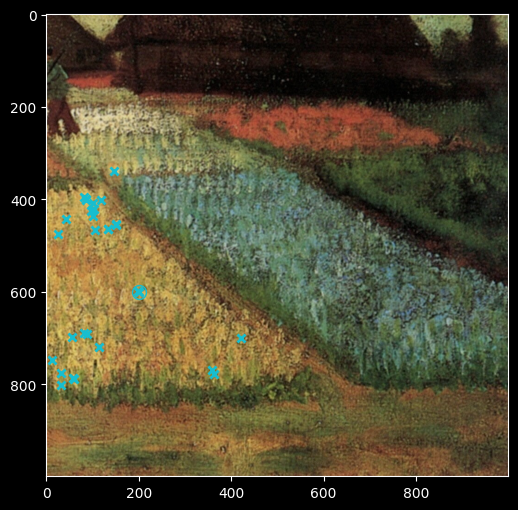

In [8]:
# Plot result in matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(imarr)
plt.plot(x, y, 'o', color='tab:cyan', mfc='none', mew=1, ms=10)
for i in range(len(k_nearest)):
    pos = flatIdx2pos(k_nearest[i][0], W)
    plt.plot(pos[1], pos[0], 'x', color='tab:cyan', mfc='none', mew=2)

In [13]:
np.save('datasets/query_vangogh1000x1000.npy', query.reshape(1, 3))

# 2) Realizando N queries

In [14]:
sH = 0
sW = 0

# Verifica se a imagem já foi criada, checando pelo arquivo .npy
if os.path.exists(f'datasets/vangogh{fullH - sH}x{fullW - sW}.npy'):
    imarr_flat = np.load(f'datasets/vangogh{fullH - sH}x{fullW - sW}.npy')
    imarr = imarr_flat.reshape(fullH - sH, fullW - sW, 3)
    H, W = imarr.shape[0], imarr.shape[1]
    total_pixels = H * W
else:
    imarr = image2array('datasets/vangogh.jpg', startHeight=sH, startWidth=sW)

    H, W = imarr.shape[0], imarr.shape[1]
    total_pixels = H * W
    imarr_flat = imarr.reshape(total_pixels, 3)
    print(f"{H} x {W} = {total_pixels} pixels")

    # Save .npy file
    np.save(f'datasets/vangogh{fullH - sH}x{fullW - sW}.npy', imarr_flat)

In [15]:
# Generate random list of queries in the form of coordinates (x, y)
m = 4
n = 4
N = m*n
np.random.seed(235)
endOfSky = 2994200 # Não quero amostras no céu
list_of_queries = np.random.randint(endOfSky, total_pixels, N)
list_of_queries[:3] = [pos2flatIdx((y, x), W) for x, y in [(1800, 1600), (2500, 1600), (2300, 1250)]]

In [16]:
queries_array = imarr_flat[list_of_queries]
print(queries_array)
np.save(f'datasets/queries_vangogh{fullH - sH}x{fullW - sW}.npy', queries_array)
print("Queries Array Shape: ", queries_array.shape)
print("Features (Flat Image) Shape: ", imarr_flat.shape)

[[0.7529412  0.5764706  0.3137255 ]
 [0.36862746 0.4745098  0.4392157 ]
 [0.5411765  0.28235295 0.1882353 ]
 [0.5372549  0.41960785 0.21568628]
 [0.7411765  0.6117647  0.34901962]
 [0.7490196  0.60784316 0.3019608 ]
 [0.6156863  0.5372549  0.25882354]
 [0.6862745  0.6039216  0.35686275]
 [0.34509805 0.34901962 0.22352941]
 [0.90588236 0.8627451  0.68235296]
 [0.23529412 0.19215687 0.10588235]
 [0.08627451 0.0627451  0.0627451 ]
 [0.7176471  0.54509807 0.4       ]
 [0.3882353  0.3372549  0.2       ]
 [0.54509807 0.5568628  0.38039216]
 [0.5803922  0.3529412  0.20392157]]
Queries Array Shape:  (16, 3)
Features (Flat Image) Shape:  (5468498, 3)


In [18]:
# Perform k-NN search for each queryk = 64
k = 32
results = []
times = []

for query in list_of_queries:
    
    t0 = time.time()
    k_nearest = knn(imarr_flat[query], k, imarr_flat, tie=0)
    results.append(k_nearest)
    t1 = time.time()
    
    dt = (t1-t0)*1000
    print(f"Query {len(results)}: {dt:.3f} ms")
    times.append(dt)

# Mean and standard deviation of time
median_time = np.median(times)
total_time = np.sum(times)
print(f"Total time: {total_time/1000:.2f}, Median time: {median_time:.3f} ms")

Query 1: 944.450 ms
Query 2: 436.236 ms
Query 3: 432.123 ms
Query 4: 457.581 ms
Query 5: 458.125 ms
Query 6: 540.334 ms
Query 7: 500.908 ms
Query 8: 502.861 ms
Query 9: 440.295 ms
Query 10: 892.563 ms
Query 11: 419.857 ms
Query 12: 439.193 ms
Query 13: 411.214 ms
Query 14: 444.345 ms
Query 15: 397.953 ms
Query 16: 427.064 ms
Total time: 8.15, Median time: 442.320 ms


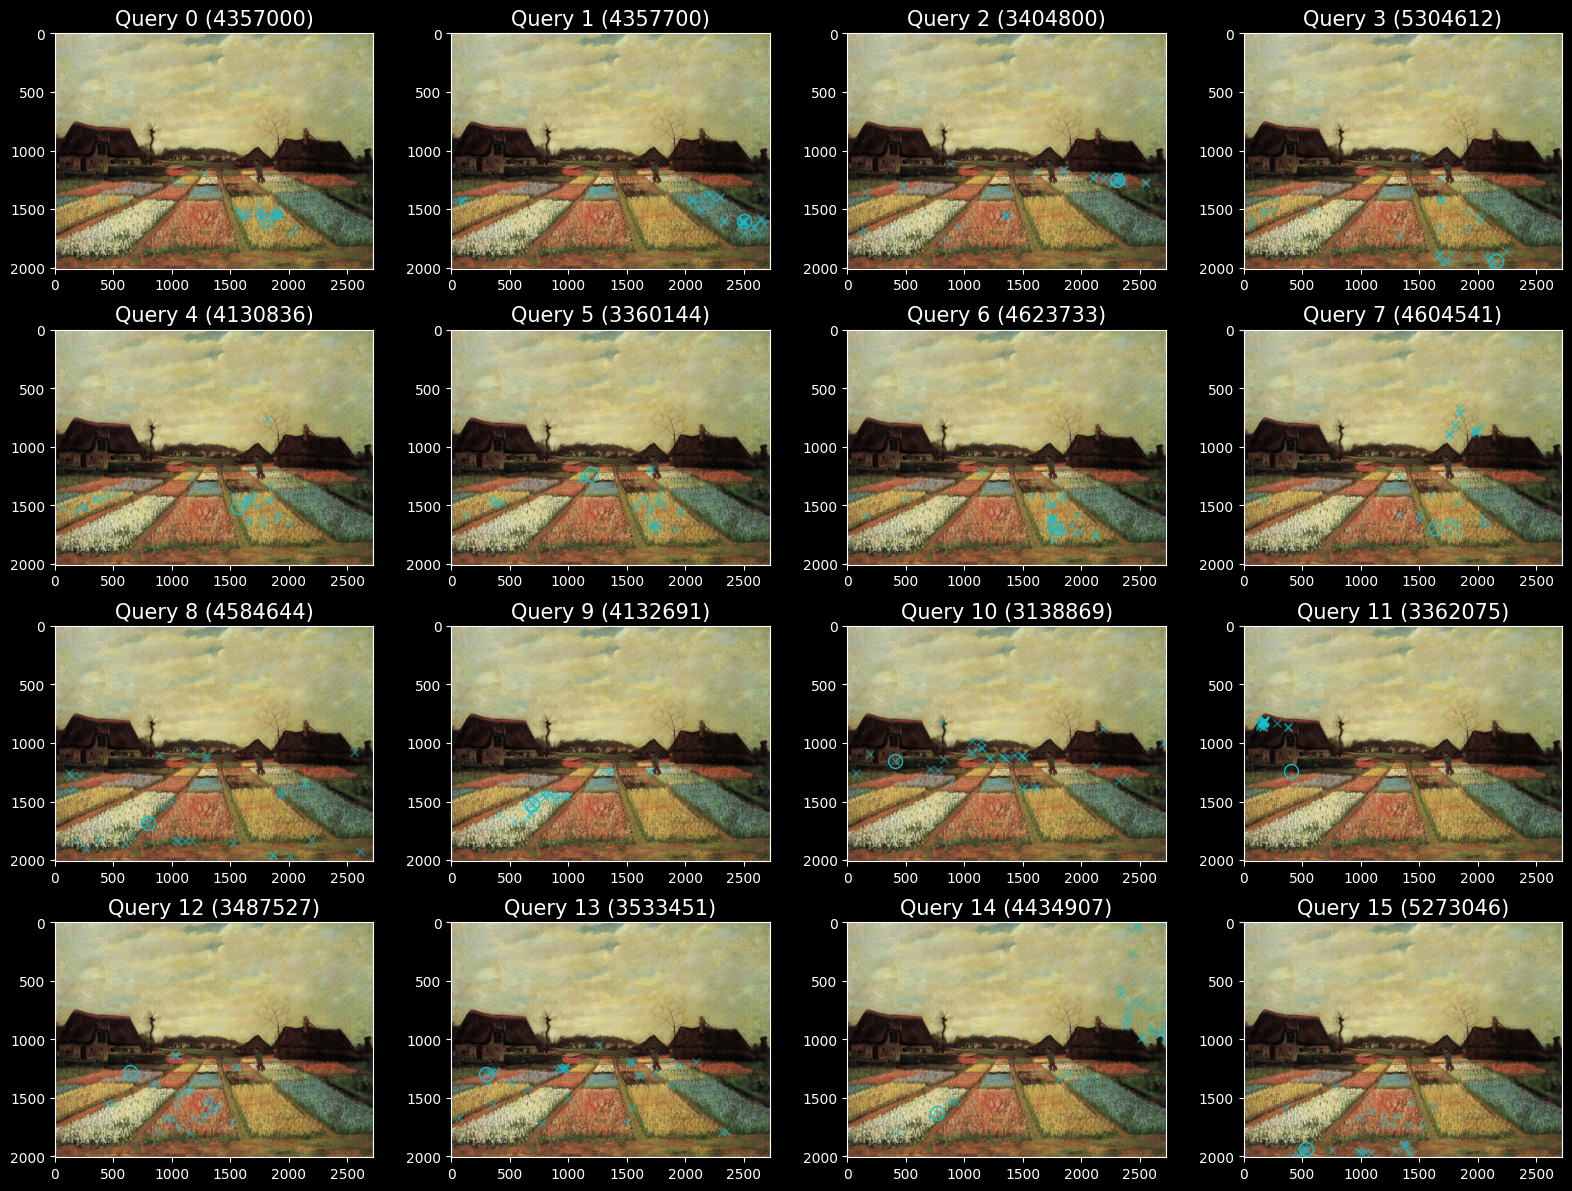

In [21]:
# Mostra diversos resultados em um grid (m x n)
plt.figure(figsize=(m*4, n*3))
for i in range(m*n):
    plt.subplot(m, n, i+1)
    
    # Plota imagem
    plt.imshow(imarr)
    q = list_of_queries[i]
    
    # Plota query
    plt.plot(flatIdx2pos(q, W)[1], flatIdx2pos(q, W)[0], 'o', color='tab:cyan', mfc='none', mew=1, ms=10)
    
    # Plota resultados da query
    for j in range(len(results[i])):
        result = results[i][j]
        pos = flatIdx2pos(result[0], W)
        plt.plot(pos[1], pos[0], 'x', color='tab:cyan', mfc='none', mew=1, alpha=0.5)
   
    plt.title(f'Query {i} ({q})', fontsize=15)

plt.tight_layout()